In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

In [ ]:
filename_train = 'df_CLOF.csv'
df = pd.read_csv(filename_train, header=0)

In [ ]:
nan_counts_per_row = df.iloc[:,2:].isnull().sum(axis=1)

print('NaN counts per row:')
print(nan_counts_per_row)
print('NaN counts per row sum:',nan_counts_per_row.sum())

NaN counts per row:
0        1
1        1
2        1
3        1
4        1
        ..
42212    0
42213    0
42214    1
42215    1
42216    0
Length: 42217, dtype: int64
NaN counts per row sum: 29483


處理不平衡資料

In [ ]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # 使用 SMOTE 平衡數據
    ('tomek', TomekLinks()),            # 使用 TomekLinks 清理數據
])

# 在訓練集上應用 pipeline
X_resampled, y_resampled = pipeline.fit_resample(df.iloc[:,3:], df['FLAG'])


In [ ]:
df1 = pd.concat([y_resampled,X_resampled], axis=1)
print(Counter(df1["FLAG"]))

Counter({0: 38637, 1: 38634})


選擇分群數

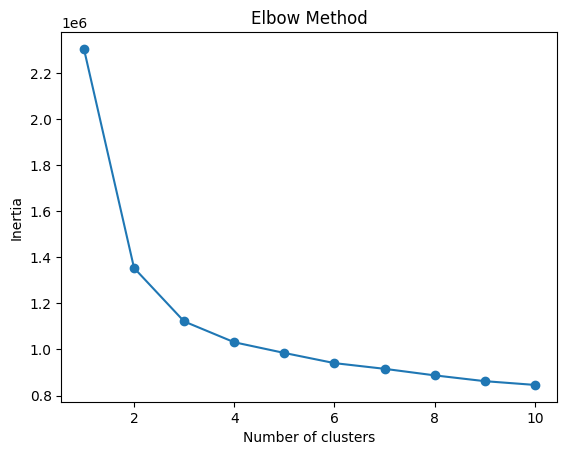

In [ ]:
# 用於保存不同K值下的集群內變異性
inertia = []

# 嘗試不同的聚類數目（K值）
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df.iloc[:,2:])
    inertia.append(kmeans.inertia_)

# 繪製Elbow圖
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


K-means

In [ ]:
kmeans = KMeans(n_clusters=3, n_init= 20)  # 假設分為 5 個簇
cluster_labels = kmeans.fit_predict(df.iloc[:,2:])

unique_labels, counts = np.unique(cluster_labels, return_counts=True)

for label, count in zip(unique_labels, counts):
    print(f"簇 {label} 的樣本數量: {count}")

簇 0 的樣本數量: 12734
簇 1 的樣本數量: 11669
簇 2 的樣本數量: 17814


LOF

In [ ]:
for cluster_id in range(kmeans.n_clusters):
    # 提取屬於該簇的樣本
    cluster_samples = df.iloc[:,2:-2][cluster_labels == cluster_id]

    # 使用 LOF 或其他方法進行異常值檢測
    cluster_lof = LocalOutlierFactor(n_neighbors=500)
    cluster_outlier_scores = cluster_lof.fit(cluster_samples)
    lof_scores = cluster_lof.negative_outlier_factor_ #分數越小越異常

    # 識別該簇中的異常值
    Flag_lof = cluster_lof.fit_predict(cluster_samples)
    cluster_outliers = cluster_samples[Flag_lof == -1]

    df.loc[cluster_labels == cluster_id, 'Flag_lof'] = Flag_lof

df['Flag_clof'] = df['Flag_lof'].apply(lambda x: 1 if x == -1 else 0)
# df['Flag_clof'] = np.where(Flag_lof == -1, 1, 0)

準確度

In [ ]:
def calculate_metrics(actual, predicted):
    TP = 0  # 真正例數
    TN = 0  # 真負例數
    FP = 0  # 假正例數
    FN = 0  # 假負例數

    for i in range(len(actual)):
        if actual[i] == 1 and predicted[i] == 1:
            TP += 1
        elif actual[i] == 0 and predicted[i] == 0:
            TN += 1
        elif actual[i] == 0 and predicted[i] == 1:
            FP += 1
        elif actual[i] == 1 and predicted[i] == 0:
            FN += 1

    accuracy = (TP + TN) / (TP + TN + FP + FN)

    if TP + FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)

    if TP + FN == 0:
        recall = 0
    else:
        recall = TP / (TP + FN)

    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score

accuracy, precision, recall, f1_score = calculate_metrics(df['FLAG'], df['Flag_clof'])

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Accuracy: 0.7143567757064689
Precision: 0.07199838432798142
Recall: 0.19905080960357344
F1 Score: 0.10574712643678161
